In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import xlrd
import operator
import math
import re
import nltk
import scipy
import openpyxl
from collections import Counter, defaultdict
from itertools import chain, product
from decimal import Decimal
from IPython.display import display, HTML
from ast import literal_eval
from pactools.grid_search import GridSearchCVProgressBar

# Sklearn imports
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import classification_report, precision_recall_fscore_support, confusion_matrix, accuracy_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

tokenizer = nltk.tokenize.RegexpTokenizer(r'\w+')
stemmer = nltk.stem.snowball.SnowballStemmer("dutch")

In [2]:
# Importing data
df = pd.read_csv("HandelingenRutte2.csv", index_col=0)
df = df.loc[df['speech category'] == 'Main Speech']
df['stemmed_text'] = df.text.apply(lambda x: ' '.join([stemmer.stem(t) for t in tokenizer.tokenize(x)]))
df['normal_text'] = df.text.apply(lambda x: ' '.join([t.lower() for t in tokenizer.tokenize(x)]))
# Uitschieters weghalen.
df.head(5)

,surname,party,text,file,speech category,date,tags,titel,stemmed_text,normal_text
175881,Wilders,PVV,\r\n \r\n Mevrouw de voo...,h-tk-20122013-100-3.xml,Main Speech,2013-06-26,"['Bestuur | Parlement', 'Financiën | Begroting']",Aanbevelingen Europese Commissie extra bezuini...,mevrouw de voorzitter dit kabinet heeft ons mo...,mevrouw de voorzitter dit kabinet heeft ons mo...
175882,Roemer,SP,\r\n \r\n Voorzitter. Vo...,h-tk-20122013-100-3.xml,Main Speech,2013-06-26,"['Bestuur | Parlement', 'Financiën | Begroting']",Aanbevelingen Europese Commissie extra bezuini...,voorzitter vorig wek plaatst werkgever werknem...,voorzitter vorige week plaatsten werkgevers we...
175883,Pechtold,D66,\r\n \r\n Voorzitter. Tw...,h-tk-20122013-100-3.xml,Main Speech,2013-06-26,"['Bestuur | Parlement', 'Financiën | Begroting']",Aanbevelingen Europese Commissie extra bezuini...,voorzitter twee maand geled kreg dit kabinet v...,voorzitter twee maanden geleden kreeg dit kabi...
175884,Van Haersma Buma,CDA,\r\n \r\n Voorzitter. Al...,h-tk-20122013-100-3.xml,Main Speech,2013-06-26,"['Bestuur | Parlement', 'Financiën | Begroting']",Aanbevelingen Europese Commissie extra bezuini...,voorzitter allen al in de eerst drie maand van...,voorzitter alleen al in de eerste drie maanden...
175889,Thieme,PvdD,\r\n \r\n Voorzitter. We...,h-tk-20122013-100-3.xml,Main Speech,2013-06-26,"['Bestuur | Parlement', 'Financiën | Begroting']",Aanbevelingen Europese Commissie extra bezuini...,voorzitter we zijn eruit eerst ontdekt de mini...,voorzitter we zijn eruit eerst ontdekte de min...


# Data Info

803.9600230083405 444.0


c:\users\m6800\appdata\local\programs\python\python36\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


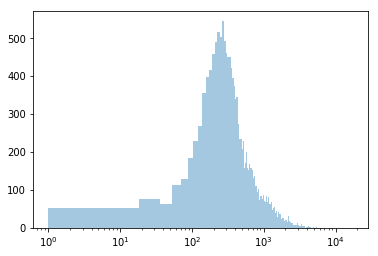

In [3]:
#leaving out all that is outside 95%
list_text = df.stemmed_text.apply(lambda x: x.split(" "))
t = [len(doc) for doc in list_text]
print(np.mean(t),np.median(t))
fit =scipy.stats.lognorm.fit(t)
ax = sns.distplot(t,bins=1000,norm_hist=False,kde=False)
ax.set_xscale('log')
plt.savefig("Verslag/Tables/lengthtextslog.png")

c:\users\m6800\appdata\local\programs\python\python36\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


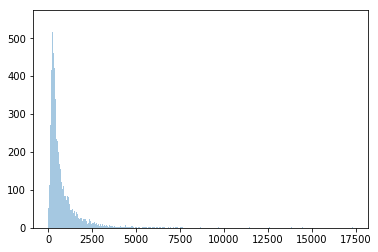

In [4]:
ax = sns.distplot(t, bins=1000, norm_hist=False,kde=False)
plt.savefig("Verslag/Tables/lengthtexts.png")

In [5]:
df = df.loc[df.stemmed_text.apply(lambda x: len(x.split(' '))) < math.exp(fit[0]+2*fit[1])]
df = df.loc[df.stemmed_text.apply(lambda x: len(x.split(' '))) > math.exp(fit[0]-2*fit[1])]
print(math.exp(fit[0]+2*fit[1]),math.exp(fit[0]-2*fit[1]))
list_text = df.stemmed_text.apply(lambda x: x.split(" "))
print("mediaan",np.median([len(doc) for doc in list_text]),"gemiddelde",np.mean([len(doc) for doc in list_text]))
print("overgebleven documenten:",len(df))

1492.675589876518 27.339307082607387
mediaan 386.0 gemiddelde 498.18961004094234
overgebleven documenten: 14899


In [6]:
len(df.file.unique())

2984

In [7]:
#https://stackoverflow.com/questions/11350770/pandas-dataframe-select-by-partial-string
# Creates a dataframe with counts of dataset per party
countdf = pd.concat([df.party.value_counts(),df[df['titel'].str.contains("Vragen van het lid")].party.value_counts(), df[~df['titel'].str.contains("Vragen van het lid")].party.value_counts()], axis=1)
countdf.columns = ['Totaal', 'Vragenuur','Debat']
countdf = countdf.sort_values("Totaal",axis=0, ascending=False)
with open("Verslag/Tables/Spreekbeurten.tex", "w") as f:
    f.write(countdf.to_latex(header=True))
countdf = countdf.sort_index()
countdf

,Totaal,Vragenuur,Debat
50PLUS,387,12,375
CDA,1901,88,1813
ChristenUnie,1068,32,1036
D66,1889,133,1756
GroenLinks,1068,47,1021
PVV,1700,49,1651
PvdA,1821,112,1709
PvdD,432,14,418
SGP,655,10,645
SP,2284,107,2177


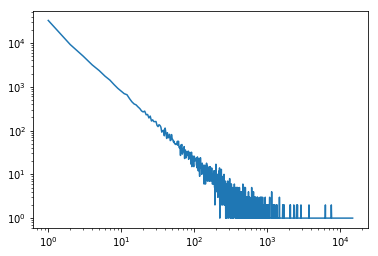

In [8]:
tekst = chain.from_iterable([list(set(doc)) for doc in list_text])
count = Counter(tekst)
samples = list(count.values())
t = Counter(samples)
t = sorted(t.items())
x, y = zip(*t)
plt.loglog(x, y)
plt.show()

# Baseline

In [9]:
simpleprediction = np.random.choice(countdf.index, len(df.party), p = [x/countdf["Totaal"].sum() for x in list(countdf['Totaal'])])
print(classification_report(df.party, simpleprediction))
print("Accuracy:",accuracy_score(df.party, np.full(len(df.party), countdf["Totaal"].idxmax())))

              precision    recall  f1-score   support

      50PLUS       0.02      0.02      0.02       387
         CDA       0.12      0.12      0.12      1901
ChristenUnie       0.07      0.07      0.07      1068
         D66       0.13      0.13      0.13      1889
  GroenLinks       0.08      0.08      0.08      1068
         PVV       0.11      0.11      0.11      1700
        PvdA       0.13      0.13      0.13      1821
        PvdD       0.02      0.02      0.02       432
         SGP       0.05      0.05      0.05       655
          SP       0.14      0.14      0.14      2284
         VVD       0.12      0.12      0.12      1694

 avg / total       0.11      0.11      0.11     14899

Accuracy: 0.15329887911940399


# Models

In [10]:
def modelsdownload(only_doen=False):
    models_df = pd.read_excel('Models.xlsx', index_col=0)
    if only_doen:
        models_df = models_df.loc[models_df.DOEN == True]
    models_dict = {}
    for x,y in zip(models_df.Classifier, models_df.PIPELINE):
        exec(compile("a="+y,'','exec'), globals())
        models_dict[x] = Pipeline(a)
    return models_df, models_dict

In [11]:
models_df, models_dict = modelsdownload(True)

# Creates a dict with parameters per classifier   
params_dict = {}
for clf in set(models_df.Classifier):
    params_df = models_df.loc[models_df.Classifier == clf]
    params_df = params_df.loc[params_df.DOEN == True]
    params_df = params_df.dropna(axis=1, how='all')
    params_df = params_df.drop([col for col in params_df.columns if "__" not in col], axis=1)
    temp_dict = {}
    for x, y in params_df.to_dict(orient='list').items():
        a = literal_eval(y[0])
        if isinstance(a, tuple):
            a = scipy.stats.uniform(a[0],a[1])
        temp_dict[x] = a   
    params_dict[clf] = temp_dict
    
text_dict = {x:y for x, y in zip(models_df.Classifier, models_df.STEMMED)}

In [12]:
scoring = ['accuracy', 'f1_weighted', 'precision_weighted','recall_weighted']
for name, pipe in models_dict.items():
    
    if text_dict[name]:
         text = list(df.normal_text)
    else:
        text = list(df.stemmed_text)
        
    gs = RandomizedSearchCV(pipe, params_dict[name], cv=5, scoring=scoring, refit = False, return_train_score = False, n_jobs=-1, verbose =10,n_iter=30)
    gs.fit(text, df.party)
    rows = pd.DataFrame(gs.cv_results_)
    # https://stackoverflow.com/questions/38231591/splitting-dictionary-list-inside-a-pandas-column-into-separate-columns
    rows = pd.concat([rows.drop(['params'], axis=1), rows['params'].apply(pd.Series)], axis=1)
    rows["name"] = name 
    rows["stemmed"] = text_dict[name]
    pd.concat([rows, pd.read_csv('Scores.csv', index_col=0)], ignore_index=True).sort_values(['mean_test_f1_weighted'], ascending=False).to_excel('Scores.xlsx')
    df4 = pd.read_excel('Models.xlsx', index_col=0)
    df4.loc[df4.Classifier == name, "DOEN"] = False
    df4.to_excel('Models.xlsx')
    print("Voltooid: %s" %name)
    
# https://stackoverflow.com/questions/46735847/save-best-params-in-gridsearch-in-a-pandas-dataframe
# https://stackoverflow.com/questions/36271413/pandas-merge-nearly-duplicate-rows-based-on-column-value?rq=1

# Best Score

In [13]:
#source: http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html#sphx-glr-auto-examples-model-selection-plot-confusion-matrix-py
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    #plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    #plt.tight_layout()
    plt.ylabel('Echte klasse')
    plt.xlabel('Voorspelde klasse')

In [50]:
# https://stackoverflow.com/questions/39662398/scikit-learn-output-metrics-classification-report-into-csv-tab-delimited-format
def classifaction_report_csv(report,save):
    report_data = []
    lines = report.split('\n')
    for line in lines[2:-3]:
        row = {}
        row_data = line.split('      ')
        row['Partij'] = row_data[-5]
        row['Precision'] = float(row_data[-4])
        row['Recall'] = float(row_data[-3])
        row['F1_score'] = float(row_data[-2])
        row['Documenten'] = int(row_data[-1])
        report_data.append(row)
    dataframe = pd.DataFrame.from_dict(report_data)
    dataframe = dataframe.reindex_axis(["Partij","Precision","Recall","F1_score","Documenten"], axis=1)
    with open("Verslag/Tables/%s.tex" %save, "w") as f:
        f.write(dataframe.to_latex(index=False))
    print(dataframe)
    return

In [51]:
# Select the classifier and parameters with highest score
def getbestpipe(file):
    scores = pd.read_csv(file, index_col=0).head(1)
    scores = scores.dropna(axis=1).reset_index(drop=True)
    scores.vect__ngram_range[0] = literal_eval(scores.vect__ngram_range[0])
    models_df, models_dict = modelsdownload(False)
    text_dict = {x:y for x, y in zip(models_df.Classifier, models_df.STEMMED)}
    pipe = models_dict[scores.name[0]]
    params = scores.drop([col for col in scores.columns if "__" not in col or "param" in col], axis=1).to_dict(orient='records')[0]
    params['vect__min_df'] = int(params['vect__min_df'])
    pipe.set_params(**params)
    stem = text_dict[scores.name[0]]
    return pipe, stem

c:\users\m6800\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


              precision    recall  f1-score   support

      50PLUS       0.73      0.58      0.65        65
         CDA       0.52      0.57      0.54       373
ChristenUnie       0.64      0.45      0.53       215
         D66       0.59      0.49      0.53       389
  GroenLinks       0.71      0.49      0.58       214
         PVV       0.57      0.83      0.67       318
        PvdA       0.56      0.48      0.52       389
        PvdD       0.78      0.67      0.72        88
         SGP       0.68      0.73      0.71       138
          SP       0.56      0.72      0.63       463
         VVD       0.57      0.48      0.52       328

 avg / total       0.59      0.59      0.58      2980

Accuracy:  0.5859060402684564


c:\users\m6800\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:15: FutureWarning: '.reindex_axis' is deprecated and will be removed in a future version. Use '.reindex' instead.
  from ipykernel import kernelapp as app


          Partij  Precision  Recall  F1_score  Documenten
0         50PLUS       0.73    0.58      0.65          65
1            CDA       0.52    0.57      0.54         373
2   ChristenUnie       0.64    0.45      0.53         215
3            D66       0.59    0.49      0.53         389
4     GroenLinks       0.71    0.49      0.58         214
5            PVV       0.57    0.83      0.67         318
6           PvdA       0.56    0.48      0.52         389
7           PvdD       0.78    0.67      0.72          88
8            SGP       0.68    0.73      0.71         138
9             SP       0.56    0.72      0.63         463
10           VVD       0.57    0.48      0.52         328


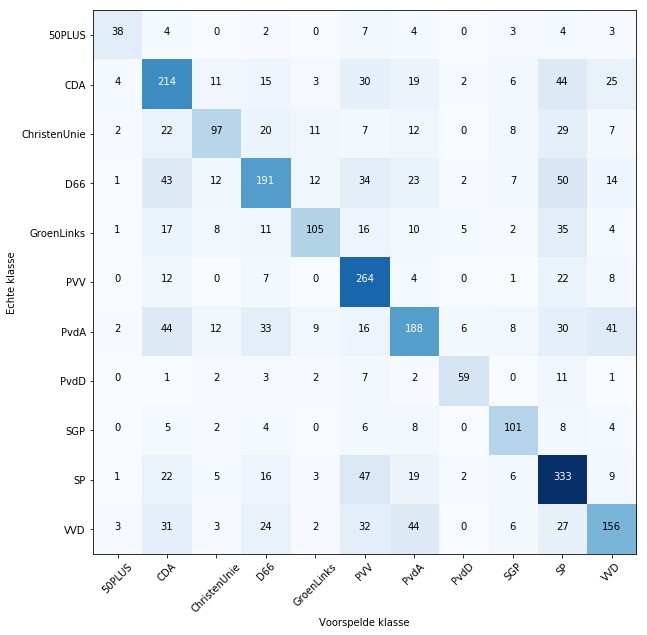

In [52]:
def traintest(file, data, save=False):
    train, test = data
    pipe, stem = getbestpipe(file)
    if stem:
        pipe.fit(train.stemmed_text, train.party)
        predicted = pipe.predict(test.stemmed_text)
    else:
        pipe.fit(train.normal_text,train.party)
        predicted = pipe.predict(test.normal_text)
    print(classification_report(test.party, predicted))
    print('Accuracy: ', accuracy_score(test.party, predicted))
                   
    plt.figure(figsize=(10, 10))
    cnf_matrix = confusion_matrix(test.party, predicted)
    plot_confusion_matrix(cnf_matrix, \
                      classes=sorted(list(test.party.unique())), \
                      title='Confusion matrix best estimator')
    if save:
        plt.savefig("Verslag/Tables/%s.png" %save)
        classifaction_report_csv(classification_report(test.party, predicted),save)
    plt.show()
    return pipe

def datasplitter(dataframe, frac):
    df_train = dataframe.sample(frac=frac)
    df_test_index = list(set(dataframe.index.tolist()) - set(df_train.index.tolist()))
    df_test = dataframe[dataframe.index.isin(df_test_index)]
    return df_train, df_test

pipe= traintest('Scores.csv', datasplitter(df, 0.8),save="confusionmatrix")

In [20]:
def mostimportantwords(pipe, countdf, filename):
    vocab = pipe.named_steps['vect'].vocabulary_
    inv_vocab = {v: k for k, v in vocab.items()}
    coefs = pipe.named_steps[[x for x in pipe.named_steps.keys() if not x=='vect'][0]].coef_
    top_words = []
    for i in range(coefs.shape[0]):
        temp_list = []
        for t in coefs[i].argsort()[-10:][::-1]:
            temp_list.append(inv_vocab[t])
        top_words.append(temp_list)
    top_words = pd.DataFrame(top_words).T
    top_words.columns = countdf.index
    with open("Verslag/Tables/%s1.tex" %filename, "w") as f:
        f.write(top_words.iloc[:,:5].to_latex(index=False))
    with open("Verslag/Tables/%s2.tex" %filename, "w") as f:
        f.write(top_words.iloc[:,5:].to_latex(index=False))
    return top_words

mostimportantwords(pipe, countdf, 'MostImportantWords')

,50PLUS,CDA,ChristenUnie,D66,GroenLinks,PVV,PvdA,PvdD,SGP,SP,VVD
0,50plus,cda,de christenunie,d66,groenlinks,pvv,de pvda,het lid ouwehand,sgp,sp,de vvd
1,lid krol naar,het cda,christenunie,leden van veldhoven,lid van tongeren,de pvv,pvda,lid ouwehand,de sgp,de sp,vvd
2,lid krol,cda fractie,de leden voordewind,lid van veldhoven,leden voortman,islamitische,pvda fractie,lid ouwehand naar,leden dijkgraaf,sp fractie,de vvd is
3,het lid krol,de cda fractie,leden voordewind,mijn fractie,de leden voortman,klever,de pvda fractie,ouwehand naar mij,de leden dijkgraaf,de sp fractie,vvd is
4,krol naar mij,de cda,lid dik,lid van meenen,lid voortman naar,graaf,de arbeid,ouwehand naar,leden van der,smaling,de vvd fractie
5,krol naar,lid omtzigt naar,lid dik faber,van veldhoven,het lid voortman,natuurlijk,van de arbeid,ouwehand,sgp fractie,lid van gerven,vvd fractie
6,van 50plus,het lid omtzigt,het lid dik,veldhoven,lid voortman,agema naar mij,de partij van,voor de dieren,de sgp fractie,lid smaling,voor de vvd
7,krol,lid omtzigt,de leden segers,d66 wil,leden van tongeren,agema naar,arbeid,thieme,mevrouw de voorzitter,het lid smaling,wat de vvd
8,50plus is,geurts,leden segers,d66 is,voortman,klever naar mij,partij van de,de dieren,mevrouw de,lid smaling naar,de vvd wil
9,lid klein naar,omtzigt,de leden dik,de leden schouw,tongeren,klever naar,partij van,dieren,de leden bisschop,lid leijten naar,vvd wil


# Without Names

In [21]:
Party_synomyns = ["Partij van de Arbeid","Socialistische Partij","Partij voor de Dieren","Volkspartij voor Vrijheid en Democratie","Partij voor de Vrijheid"]
partijnamen = list(df.party.unique()) + Party_synomyns
partijnamen += ["[Hh]et "+ x for x in partijnamen] + ["[Dd]e "+ x for x in partijnamen]
partijnamen = re.compile('|'.join(partijnamen))
kamerlidnamen = re.compile('|'.join(df.surname.unique()) + "|Dijkstra|Van Dijk|Van Nieuwenhuizen|Baay|Berndsen|Jansen|Günal|Schut|Nijkerken|Buma|Venrooy|Mulder|De Vries|Berckmoes|Van Dijck|Pia")
df['text'] = df.text.apply(lambda x: re.sub(kamerlidnamen,"xxxxx",re.sub(partijnamen,"yyyyy",x)).lower().replace("xxxxx",'KAMERlIDNAAM').replace("yyyyy", 'PARTIJNAAM'))
df['stemmed_text'] = df.text.apply(lambda x: ' '.join([stemmer.stem(t) for t in tokenizer.tokenize(x)]))
df['normal_text'] = df.text.apply(lambda x: ' '.join([t for t in tokenizer.tokenize(x)]))
df.head(5)

,surname,party,text,file,speech category,date,tags,titel,stemmed_text,normal_text
175881,Wilders,PVV,\r\n \r\n mevrouw de voo...,h-tk-20122013-100-3.xml,Main Speech,2013-06-26,"['Bestuur | Parlement', 'Financiën | Begroting']",Aanbevelingen Europese Commissie extra bezuini...,mevrouw de voorzitter dit kabinet heeft ons mo...,mevrouw de voorzitter dit kabinet heeft ons mo...
175882,Roemer,SP,\r\n \r\n voorzitter. vo...,h-tk-20122013-100-3.xml,Main Speech,2013-06-26,"['Bestuur | Parlement', 'Financiën | Begroting']",Aanbevelingen Europese Commissie extra bezuini...,voorzitter vorig wek plaatst werkgever werknem...,voorzitter vorige week plaatsten werkgevers we...
175883,Pechtold,D66,\r\n \r\n voorzitter. tw...,h-tk-20122013-100-3.xml,Main Speech,2013-06-26,"['Bestuur | Parlement', 'Financiën | Begroting']",Aanbevelingen Europese Commissie extra bezuini...,voorzitter twee maand geled kreg dit kabinet v...,voorzitter twee maanden geleden kreeg dit kabi...
175884,Van Haersma Buma,CDA,\r\n \r\n voorzitter. al...,h-tk-20122013-100-3.xml,Main Speech,2013-06-26,"['Bestuur | Parlement', 'Financiën | Begroting']",Aanbevelingen Europese Commissie extra bezuini...,voorzitter allen al in de eerst drie maand van...,voorzitter alleen al in de eerste drie maanden...
175889,Thieme,PvdD,\r\n \r\n voorzitter. we...,h-tk-20122013-100-3.xml,Main Speech,2013-06-26,"['Bestuur | Parlement', 'Financiën | Begroting']",Aanbevelingen Europese Commissie extra bezuini...,voorzitter we zijn eruit eerst ontdekt de mini...,voorzitter we zijn eruit eerst ontdekte de min...


c:\users\m6800\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


              precision    recall  f1-score   support

      50PLUS       0.79      0.62      0.70        80
         CDA       0.52      0.56      0.54       373
ChristenUnie       0.70      0.53      0.60       213
         D66       0.56      0.53      0.55       367
  GroenLinks       0.61      0.47      0.53       226
         PVV       0.62      0.81      0.71       328
        PvdA       0.53      0.48      0.50       403
        PvdD       0.73      0.83      0.78        71
         SGP       0.69      0.78      0.73       124
          SP       0.58      0.70      0.64       454
         VVD       0.55      0.45      0.50       341

 avg / total       0.59      0.59      0.59      2980

Accuracy:  0.5909395973154362


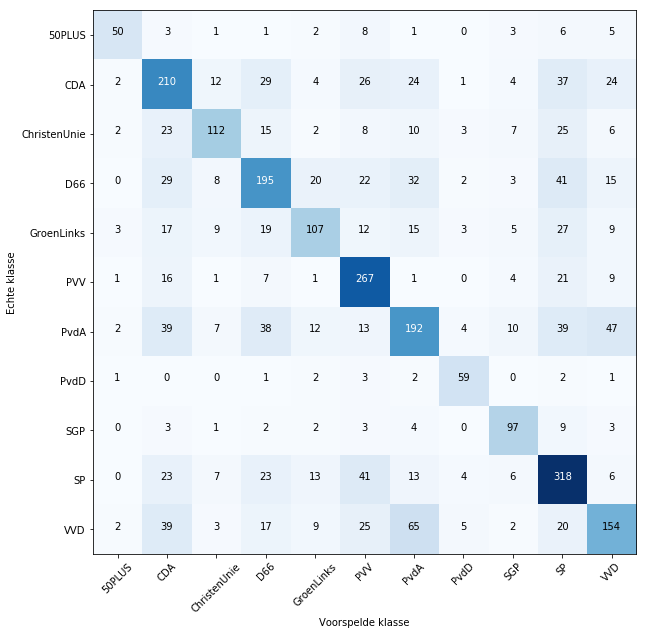

In [22]:
pipe = traintest('Scores.csv', datasplitter(df, 0.8), save="withoutnames")

In [23]:
mostimportantwords(pipe, countdf, 'MostImportantWordsWithoutNames')

,50PLUS,CDA,ChristenUnie,D66,GroenLinks,PVV,PvdA,PvdD,SGP,SP,VVD
0,gepensioneerden,PARTIJNAAM fractie,dementie,mijn fractie,zou,islamitische,circulaire economie,dieren,mevrouw de voorzitter,huurders,aruba
1,ouderen,inwoners,voedselverspilling,natuurlijk,schone energie,natuurlijk,circulaire,aarde,mevrouw de,zegt,volgens mij
2,plussers,regering,inderdaad,buitengewoon,persoonsgebonden,al,jongeren,de aarde,beantwoording,voorstellen,PARTIJNAAM
3,oudere,PARTIJNAAM,gezinnen,mijn,belastingontwijking,nederland,en om,burgers,punt,segregatie,regelgeving
4,koopkrachtontwikkeling,limburg,mensenhandel,het kabinet,kamer hierover te,miljard,open standaarden,milieu,voor de beantwoording,bezuinigingen,speelveld
5,50 plussers,de regering,zullen,vandaag,in elk geval,miljarden,kinderen,natuur,de beantwoording,de bevolking,banen
6,50,echt,horeca,fractie,elk geval,onze,mijn partij,constaterende dat,bewindslieden,mensen,essentieel
7,werkenden,hier,onder,belangrijk,in elk,de islam,redelijk,constaterende,nadrukkelijk,armoede,aangegeven
8,overwegende,diverse,het ingezetenencriterium,minister,vluchtelingen,islam,daarbij,de bio,wel,mening dat,ondernemers
9,overwegende dat,zorginstellingen,onder meer,kansen,budget,brussel,de regering tevens,bio,je,bevolking,PARTIJNAAM fractie


# Confusion matrix analyse

In [24]:
def traintest2(file, data, save=False):
    train, test = data
    pipe, stem = getbestpipe(file)
    if stem:
        pipe.fit(train.stemmed_text, train.party)
        predicted = pipe.predict(test.stemmed_text)
    else:
        pipe.fit(train.normal_text,train.party)
        predicted = pipe.predict(test.normal_text)
    cm = confusion_matrix(test.party, predicted)
    cm2 = np.zeros(cm.shape)
    tot = len(predicted)
    ggg = defaultdict(int)
    for i in range(cm.shape[0]):
        for j in range(cm.shape[0]):
            if i!=j:
                cm2[i,j] = (sum(cm[i,:])-cm[i,i]) * (sum(cm[j,:])/(tot-sum(cm[i,:])))
                ggg[(i,sum(cm[i,:]))]+=cm2[i,j]
            else:
                cm2[i,j] = cm[i,j]
                
    nextcm = cm-cm2
    mix = []
    regering = []
    oppositie = []
    for i in range(cm.shape[0]):
        for j in range(cm.shape[0]):
            if i!=j:
                if i in [6,10] and j in [6,10]:
                    regering.append(nextcm[i,j])
                elif i in [0,1,2,3,4,5,7,8,9] and j in [0,1,2,3,4,5,7,8,9]:
                    oppositie.append(nextcm[i,j])
                else:
                    mix.append(nextcm[i,j])
    return pipe, oppositie, regering, mix, ggg

In [25]:
o = []
m = []
r = []
g = {}
for i in range(50):
    pipe, oppositie, regering, mix, ggg=traintest2('Scores.csv', datasplitter(df, 0.8))
    g ={**g, **ggg}
    o.append(oppositie)
    r.append(regering)
    m.append(mix)

c:\users\m6800\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
c:\users\m6800\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
c:\users\m6800\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
c:\users\m6800\appdata\local\programs\python\pyth

(0.8104151552507787, 8.70293135938899e-80)

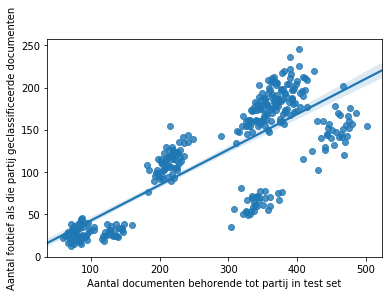

In [30]:
(keys,values) = zip(*g.items())
_, keys = zip(*keys)
ax = sns.regplot(pd.Series(keys,name="Aantal documenten behorende tot partij in test set"), pd.Series(values,name="Aantal foutief als die partij geclassificeerde documenten"))
fig = ax.get_figure()
fig.savefig('Verslag/Tables/Correlation.png') 
scipy.stats.pearsonr(keys,values)

c:\users\m6800\appdata\local\programs\python\python36\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


0.19713313083383957

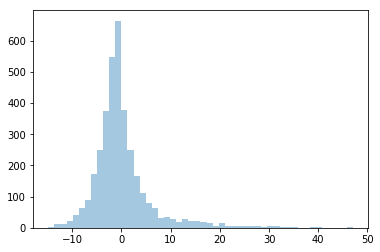

In [40]:
ax = sns.distplot(list(chain.from_iterable(o)),kde=False)
fig = ax.get_figure()
fig.savefig('Verslag/Tables/Oppositie.png') 
np.mean(list(chain.from_iterable(o)))

c:\users\m6800\appdata\local\programs\python\python36\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


28.685661311153343

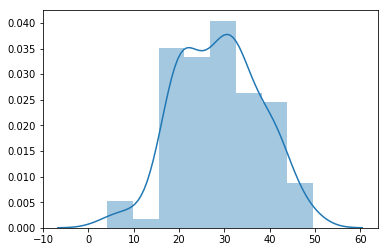

In [35]:
ax = sns.distplot(list(chain.from_iterable(r)),kde=False)
fig = ax.get_figure()
fig.savefig('Verslag/Tables/Regering.png') 
np.mean(list(chain.from_iterable(r)))

c:\users\m6800\appdata\local\programs\python\python36\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


-1.9879141122873094

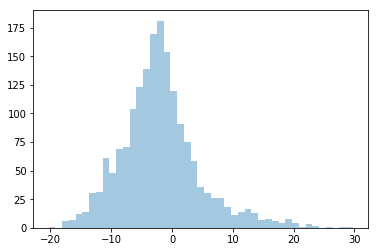

In [42]:
ax = sns.distplot(list(chain.from_iterable(m)),kde=False)
fig = ax.get_figure()
fig.savefig('Verslag/Tables/Mix.png') 
np.mean(list(chain.from_iterable(m)))

c:\users\m6800\appdata\local\programs\python\python36\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


-8.268133652481165e-17

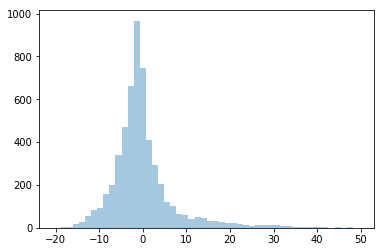

In [43]:
ax = sns.distplot(list(chain.from_iterable(m))+list(chain.from_iterable(o))+list(chain.from_iterable(r)),kde=False)
fig = ax.get_figure()
fig.savefig('Verslag/Tables/Totaal.png')
np.mean(list(chain.from_iterable(m))+list(chain.from_iterable(o))+list(chain.from_iterable(r)))

# Regering & Oppositie

In [ ]:
df['PartijStatus'] = df['party'].map({'CDA': 'Oppositie', 'ChristenUnie': 'Oppositie', 'D66':'Oppositie', 'SGP':'Oppositie', 'VVD':'Regering', 'SP':'Oppositie','PvdD':'Oppositie','GroenLinks':'Oppositie','PvdA':'Regering','50PLUS':'Oppositie'})
pipe = traintest('Scores.csv', datasplitter(df.dropna(), 0.8))

In [ ]:
# regering
vocab = pipe.named_steps['vect'].vocabulary_
inv_vocab = {v: k for k, v in vocab.items()}
coefs = pipe.named_steps[[x for x in pipe.named_steps.keys() if not x=='vect'][0]].coef_
top_words = []
for i in range(coefs.shape[0]):
    temp_list = []
    for t in coefs[i].argsort()[-10:][::-1]:
        temp_list.append(inv_vocab[t])
    top_words.append(temp_list)
top_words = pd.DataFrame(top_words).T
top_words

In [ ]:
# oppositie
vocab = pipe.named_steps['vect'].vocabulary_
inv_vocab = {v: k for k, v in vocab.items()}
coefs = pipe.named_steps[[x for x in pipe.named_steps.keys() if not x=='vect'][0]].coef_
top_words = []
for i in range(coefs.shape[0]):
    temp_list = []
    for t in coefs[i].argsort()[:10][::-1]:
        temp_list.append(inv_vocab[t])
    top_words.append(temp_list)
top_words = pd.DataFrame(top_words).T
top_words

# Woorden Balkenende 4

In [ ]:
# Importing data
dfb4 = pd.read_csv("HandelingenBalkenende4.csv", index_col=0)
dfb4 = dfb4.loc[dfb4['speech category'] == 'Main Speech']
dfb4['stemmed_text'] = dfb4.text.apply(lambda x: ' '.join([stemmer.stem(t) for t in tokenizer.tokenize(x)]))
dfb4 = dfb4.loc[dfb4.stemmed_text.apply(lambda x: len(x.split(' '))) < math.exp(fit[0]+2*fit[1])]
dfb4 = dfb4.loc[dfb4.stemmed_text.apply(lambda x: len(x.split(' '))) > math.exp(fit[0]-2*fit[1])]
dfb4.head(5)

In [ ]:
# Creates a dataframe with counts of dataset per party
countdfb4 = dfb4.party.value_counts().sort_index()
countdfb4

In [ ]:
Party_synomyns = ["Partij van de Arbeid","Socialistische Partij","Partij voor de Dieren","Volkspartij voor Vrijheid en Democratie","Partij voor de Vrijheid"]
partijnamen = list(dfb4.party.unique()) + Party_synomyns
partijnamen += ["[Hh]et "+ x for x in partijnamen] + ["[Dd]e "+ x for x in partijnamen]
partijnamen = re.compile('|'.join(partijnamen))
kamerlidnamen = re.compile('|'.join(dfb4.surname.unique())+"|Kortenhorst|Wiegman|De Roos|Schreijer|Willemse|Snijder|Van Vroonhoven|Dezentjé Hamming|Blanksma|Buma|De Pater|Ortega|Madsen")
dfb4['text'] = dfb4.text.apply(lambda x: re.sub(kamerlidnamen,"xxxxx",re.sub(partijnamen,"yyyyy",x)).lower().replace("xxxxx",'KAMERlIDNAAM').replace("yyyyy", 'PARTIJNAAM'))
dfb4['stemmed_text'] = dfb4.text.apply(lambda x: ' '.join([stemmer.stem(t) for t in tokenizer.tokenize(x)]))
dfb4['normal_text'] = dfb4.text.apply(lambda x: ' '.join([t for t in tokenizer.tokenize(x)]))
dfb4.head(5)

In [ ]:
pipe = traintest('Scores.csv', datasplitter(dfb4, 0.8))

In [ ]:
mostimportantwords(pipe, countdfb4, 'MostImportantWordsWithoutNames')

# Vergelijken

In [ ]:
pipe = traintest('Scores.csv', (df[df.party != '50PLUS'],dfb4))

In [ ]:
pipe = traintest('Scores.csv', (dfb4,df[df.party != '50PLUS']))

# Links / Rechts vergelijken

In [ ]:
df['Kieskompas'] = df['party'].map({'CDA': 'Rechts', 'ChristenUnie': 'Rechts', 'D66':'Rechts', 'SGP':'Rechts', 'VVD':'Rechts', 'SP':'Links','PvdD':'Links','GroenLinks':'Links','PvdA':'Links','50PLUS':'Links'})
pipe, predicted = traintest('Scores.csv', datasplitter(df.dropna(), 0.8))

In [ ]:
pipe, _ = getbestpipe('Scores.csv')
df_train = df.dropna().sample(frac=0.8)
df_test_index = list(set(df.index.tolist()) - set(df_train.index.tolist()))
df_test = df.dropna()[df.dropna().index.isin(df_test_index)]
pipe.fit(df_train.withoutnames, df_train.Kieskompas)
predicted = pipe.predict(df_test.withoutnames)
print(classification_report(df_test.Kieskompas, predicted))

# Git

In [39]:
!git pull
!git add CompleteNotebook.ipynb
!git add Scraper.ipynb
!git add Scores.csv
!git add Scriptie_Sprekers_TK.pdf
!git add Verslag/Tables/Spreekbeurten.tex
!git add Verslag/Tables/MostImportantWordsWithoutNames1.tex
!git add Verslag/Tables/MostImportantWordsWithoutNames2.tex
!git add Verslag/Tables/MostImportantWords1.tex
!git add Verslag/Tables/Correlation.png
!git add Verslag/Tables/confusionmatrix.tex
!git add Verslag/Tables/MostImportantWords2.tex
!git add Verslag/Tables/lengthtextslog.png
!git add Verslag/Tables/lengthtexts.png
!git add Verslag/Tables/Totaal.png
!git add Verslag/Tables/Mix.png
!git add Verslag/Tables/Regering.png
!git add Verslag/Tables/Oppositie.png
!git add Models.xlsx
!git add Verslag/Tables/confusionmatrix.png
!git commit -m Update
!git push

Updating 612a855..3a249b4
Fast-forward
 Verslag/evaluation.tex   | 20 +++++++++++++++++++-
 Verslag/introduction.tex |  2 +-
 Verslag/methodology.tex  |  2 +-
 Verslag/related_work.tex |  8 +++++++-
 4 files changed, 28 insertions(+), 4 deletions(-)


From https://github.com/jaspervdh96/Scriptie-Sprekers-TK
   612a855..3a249b4  master     -> origin/master
c:\users\m6800\appdata\local\programs\python\python36\lib\site-packages\IPython\utils\_process_win32.py:131: ResourceWarning: unclosed file <_io.BufferedWriter name=8>
  return process_handler(cmd, _system_body)
c:\users\m6800\appdata\local\programs\python\python36\lib\site-packages\IPython\utils\_process_win32.py:131: ResourceWarning: unclosed file <_io.BufferedReader name=9>
  return process_handler(cmd, _system_body)
c:\users\m6800\appdata\local\programs\python\python36\lib\site-packages\IPython\utils\_process_win32.py:131: ResourceWarning: unclosed file <_io.BufferedReader name=10>
  return process_handler(cmd, _system_body)
The file will have its original line endings in your working directory.


[master 7082350] Update
 2 files changed, 94 insertions(+), 8 deletions(-)
 create mode 100644 Verslag/Tables/Mix.png


To https://github.com/jaspervdh96/Scriptie-Sprekers-TK.git
   3a249b4..7082350  master -> master
